# 수강생분의 이름, 학번을 반영해주세요.

In [ ]:
id = '20197125'
name = '김현민'
print(id, name)

20197125 김현민


할당된 GPU 상태 확인

In [ ]:
!nvidia-smi

Mon Oct 17 03:06:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


폴더 경로 설정

In [ ]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/AI_week_7/'  # 과제 파일 업로드한 경로 반영

필요 패키지 로드

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import random

seed 일치시키기 (실험결과 재현성을 위함)

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        if torch.cuda.device_count() > 1:
            torch.cuda.manual_seed_all(seed) # if use multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

인공신경망(ANN) 정의

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        """
        self.fc1 = nn.Linear(32*32*3, 256)  # 3072차원(32x32x3) -> 256차원으로 축소
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 100)  # 출력값의 차원은 판별할 클래스 수인 100으로 설정 (CIFAR100은 100종 판별 문제)
        """
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 100)

    def forward(self, x):
        x = x.float()
        """
        h1 = F.relu(self.fc1(x.view(-1, 32*32*3)))  # view 함수로 tensor 형태 변경 (배치수, axis_0, axis_1, ...)
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        """
        h1 = F.relu(self.fc1(x.view(-1, 32*32*3)))  # view 함수로 tensor 형태 변경 (배치수, axis_0, axis_1, ...)
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

print("init model done")

init model done


모델 학습을 위한 하이퍼파라미터 셋팅

In [ ]:
batch_size = 64  # 학습 배치 크기
test_batch_size = 1000  # 테스트 배치 크기 (학습 과정을 제외하므로 더 큰 배치 사용 가능)
max_epochs = 100  # 학습 데이터셋 총 훈련 횟수
lr = 0.005  # 학습률
momentum = 0.5  # SGD에 사용할 모멘텀 설정 (추후 딥러닝 최적화 과정에서 설명)
seed = 1  # 결과 재현을 위한 seed 설정
log_interval = 200  # interval 때마다 로그 남김

use_cuda = torch.cuda.is_available()  # GPU cuda 사용 여부 확인

seed_everything(seed)  # seed 일치시키기 (실험결과 재현성을 위함)

device = torch.device("cuda" if use_cuda else "cpu")  # GPU cuda 사용하거나 없다면 CPU 사용

kwargs = {'pin_memory': True} if use_cuda else {}  # pin_memory: 고정된 메모리 영역 사용

print("set vars and device done")

set vars and device done


데이터 로더 정의 (학습용, 테스트용 따로 정의)

In [ ]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.RandomHorizontalFlip(p=0.5),
                 transforms.RandomVerticalFlip(p=0.5),
                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 임의의 값으로 초기화 (일반적으로는 학습 데이터셋의 평균, 표준편차 사용)

# CIFAR-10 link: https://www.cs.toronto.edu/~kriz/cifar.html
# 학습용 데이터 로더 (CIFAR-100 학습 데이터셋 사용)
train_loader = torch.utils.data.DataLoader(
  datasets.CIFAR100(os.path.join(workspace_path, 'data'), train=True, download=True, 
                   transform=transform), 
    batch_size = batch_size, shuffle=True, drop_last=True, **kwargs)  # drop_last: 마지막 미니배치 크기가 batch_size 이하면 drop 

# 테스트용 데이터 로더 (CIFAR-100 테스트 데이터셋 사용)
test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR100(os.path.join(workspace_path, 'data'), train=False, download=True,
                         transform=transform), 
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


모델, 최적화 알고리즘, 손실 함수 정의

In [ ]:
model = Net().to(device)  # 모델 정의
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # 최적화 알고리즘 정의 (SGD 사용)
criterion = nn.CrossEntropyLoss()  # 손실 함수 정의 (CrossEntropy 사용)

AverageMeter 정의

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

학습, 테스트용 함수 정의

In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()  # 모델 학습 모드 설정
    summary_loss = AverageMeter()  # 학습 손실값 기록 초기화
    summary_acc = AverageMeter() # 학습 정확도 기록 초기화
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
        optimizer.zero_grad()  # gradient 0으로 초기화
        output = model(data)  # 모델에 입력값 feed-forward
        loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
        loss.backward()  # 손실값 역전파 (각 계층에서 gradient 계산, pytorch는 autograd로 gradient 자동 계산)
        optimizer.step()  # 모델의 파라미터 업데이트 (gradient 이용하여 파라미터 업데이트)
        summary_loss.update(loss.detach().item())  # 손실값 기록
        pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
        correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
        summary_acc.update(correct / data.size(0))  # 정확도 기록
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tAverage loss: {:.4f}, Accuracy: {:.4f}'.format(
                epoch+1, max_epochs, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), summary_loss.avg, summary_acc.avg))
            
    return summary_loss.avg, summary_acc.avg

def test(log_interval, model, device, test_loader):
    model.eval()  # 모델 검증 모드 설정 (inference mode)
    summary_loss = AverageMeter()  # 테스트 손실값 기록 초기화
    summary_acc = AverageMeter() # 테스트 정확도 기록 초기화
    with torch.no_grad():  # 검증 모드이므로 gradient 계산안함
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 현재 미니 배치의 데이터, 정답 불러옴
            output = model(data)  # 모델에 입력값 feed-forward
            loss = criterion(output, target)  # 예측값(클래스 별 score)과 정답간의 손실값 계산
            summary_loss.update(loss.detach().item())  # 손실값 기록
            pred = output.argmax(dim=1, keepdim=True)  # 예측값 중에서 최고 score를 달성한 클래스 선발
            correct = pred.eq(target.view_as(pred)).sum().item()  # 정답과 예측 클래스가 일치한 개수
            summary_acc.update(correct / data.size(0))  # 정확도 기록

    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n'.format
          (summary_loss.avg, summary_acc.avg))  # 정답을 맞춘 개수 / 테스트셋 샘플 수 -> Accuracy

    return summary_loss.avg, summary_acc.avg

학습, 테스트, 모델 저장 수행

In [ ]:
best_acc = 0
for epoch in range(max_epochs):
    train_loss, train_acc = train(log_interval, model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(log_interval, model, device, test_loader)

    # 테스트에서 best accuracy 달성하면 모델 저장
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model, os.path.join(workspace_path, f'cifar100_ann_model_best_acc_{epoch+1}-epoch.pt'))
        print(f'# save model: cifar100_ann_model_best_acc_{epoch+1}-epoch.pt\n')

Train Epoch: 1/100 [0/50000 (0%)]	Average loss: 4.6333, Accuracy: 0.0156
Train Epoch: 1/100 [12800/50000 (26%)]	Average loss: 4.6089, Accuracy: 0.0110
Train Epoch: 1/100 [25600/50000 (51%)]	Average loss: 4.6069, Accuracy: 0.0117
Train Epoch: 1/100 [38400/50000 (77%)]	Average loss: 4.6061, Accuracy: 0.0123

Test set: Average loss: 4.5991, Accuracy: 0.0181

# save model: cifar100_ann_model_best_acc_1-epoch.pt

Train Epoch: 2/100 [0/50000 (0%)]	Average loss: 4.6209, Accuracy: 0.0156
Train Epoch: 2/100 [12800/50000 (26%)]	Average loss: 4.5969, Accuracy: 0.0190
Train Epoch: 2/100 [25600/50000 (51%)]	Average loss: 4.5940, Accuracy: 0.0193
Train Epoch: 2/100 [38400/50000 (77%)]	Average loss: 4.5911, Accuracy: 0.0204

Test set: Average loss: 4.5725, Accuracy: 0.0246

# save model: cifar100_ann_model_best_acc_2-epoch.pt

Train Epoch: 3/100 [0/50000 (0%)]	Average loss: 4.5907, Accuracy: 0.0000
Train Epoch: 3/100 [12800/50000 (26%)]	Average loss: 4.5635, Accuracy: 0.0270
Train Epoch: 3/100 [25600

# 실습 과제: 개선시도 2가지, 0.1825 보다 높은 test accuracy 달성
아래의 2가지를 모두 개선 시도하여 0.1825 보다 높은 test accuracy 달성하시오. 단, 학습된 모델이나 CNN 사용 불가합니다.

* 1) 네트워크 구조 개선(Net 정의)
* 2) 학습 하이퍼파라미터 변경

- torchvision: 데이터셋, 데이터증대 함수 제공 (https://pytorch.org/vision/stable/transforms.html)
- CIFAR link: https://www.cs.toronto.edu/~kriz/cifar.html

# 첫번째 시도
- 네트워크 구조 개선
    - 은닉층을 1개 더 증설하여 4개의 은닉층을 만들었음
- 학습 하이퍼 파라미터 변경
    - max_epochs = 10 -> 30 에폭을 증가하여 학습량을 늘려주었음
    - lr = 0.01 -> 0.005 에폭이 증가하여 과대적합이 일어날 수 있다고 판단, 러닝레이트를 조정해주었음
- 결과
    - acc : 0.2086
    - 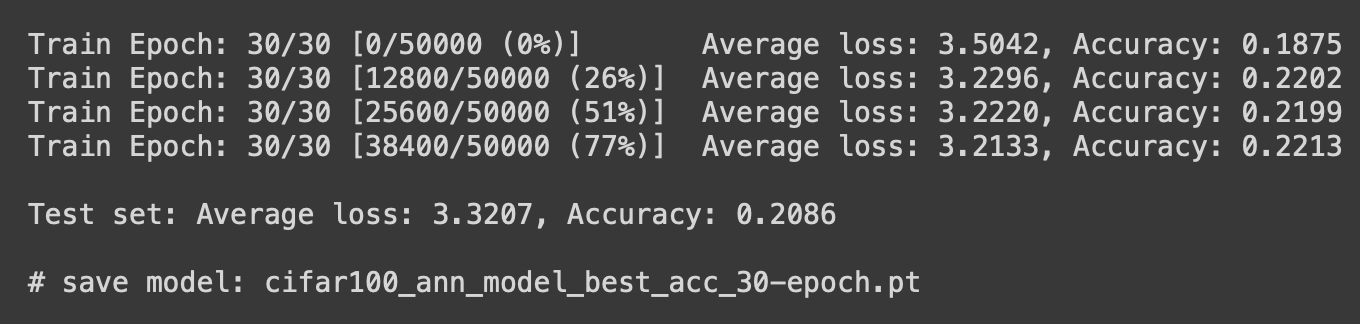

# 두번째 시도
- 첫번째 시도 그대로 하이퍼파라미터만 조정
- 에폭 30 -> 100
- 결과
    - acc : 0.2738
    - 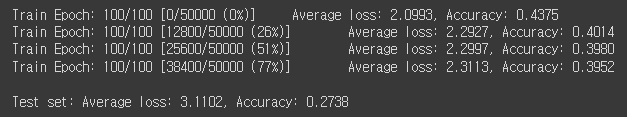